Time Series Forecasting with XGBoost

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [100]:
auclandweather = pd.read_csv('data/auckland_rain_temp_statsNZ.csv')
auclandweather.tail()


,date,rainfall(mm),tavg,tmax,tmin
20814,2022-12-27,0.0,21.0,25.1,17.0
20815,2022-12-28,0.0,22.4,26.7,18.1
20816,2022-12-29,0.0,21.8,25.1,18.6
20817,2022-12-30,0.0,21.6,24.0,19.1
20818,2022-12-31,0.8,21.3,25.2,17.4


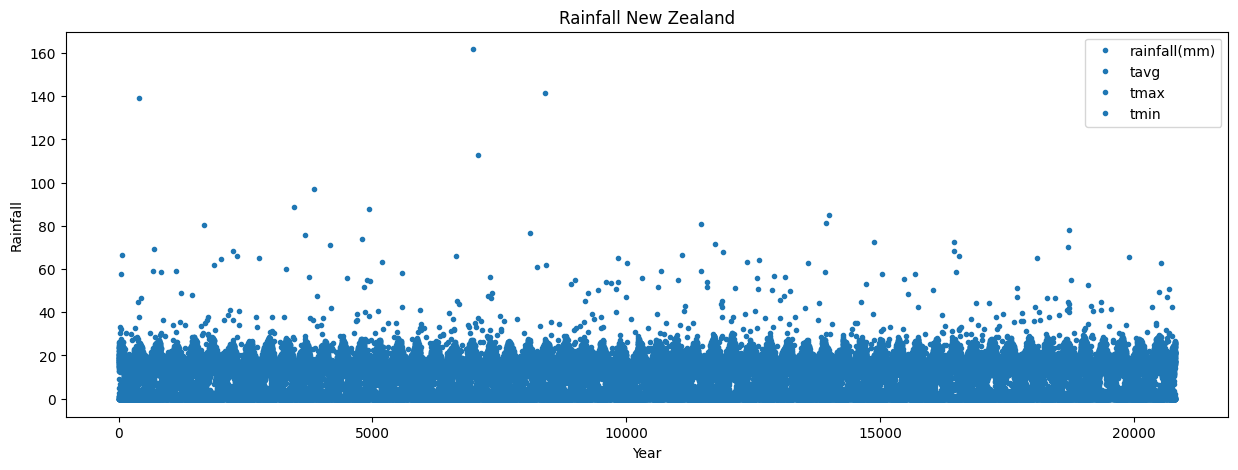

In [101]:
auclandweather.plot(style='.', figsize=(15,5), color=color_pal[0], title='Rainfall New Zealand', xlabel="Year", ylabel='Rainfall')
plt.show()

In [102]:
auclandweather.index

RangeIndex(start=0, stop=20819, step=1)

In [103]:
auclandweather.columns

Index(['date', 'rainfall(mm)', 'tavg', 'tmax', 'tmin'], dtype='object')

<Axes: title={'center': 'Rainfall Auckland 1960 to 2023 (NOAA)'}, xlabel='Year', ylabel='Rainfall'>

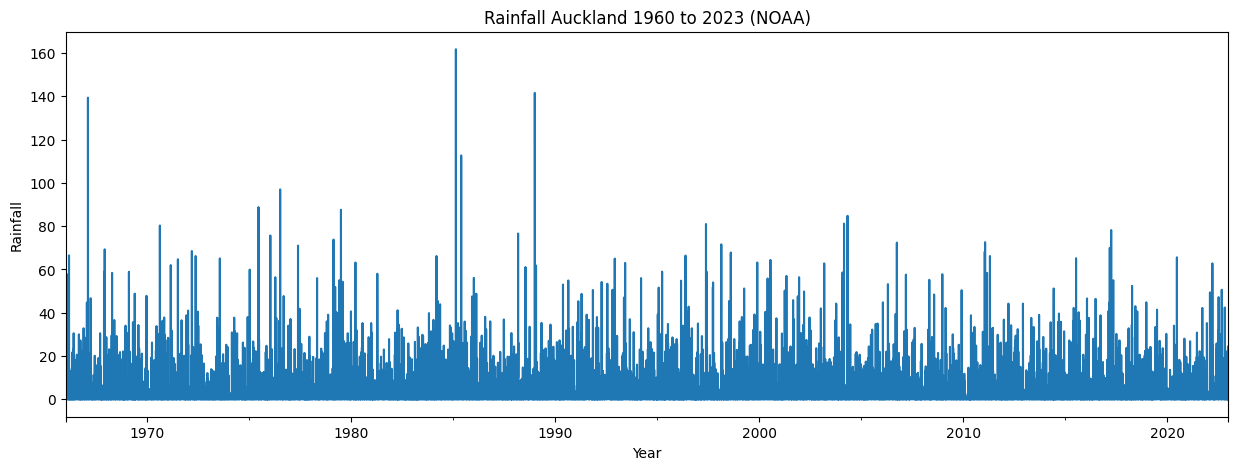

In [104]:
auclandweather = auclandweather.set_index('date')
auclandweather.index = pd.to_datetime(auclandweather.index)
auclandweather['rainfall(mm)'].plot(figsize=(15,5),  title='Rainfall Auckland 1960 to 2023 (NOAA)', xlabel="Year", ylabel='Rainfall')

<Axes: title={'center': 'Rainfall Auckland 1994 to 2023 (NOAA)'}, xlabel='Year', ylabel='Rainfall'>

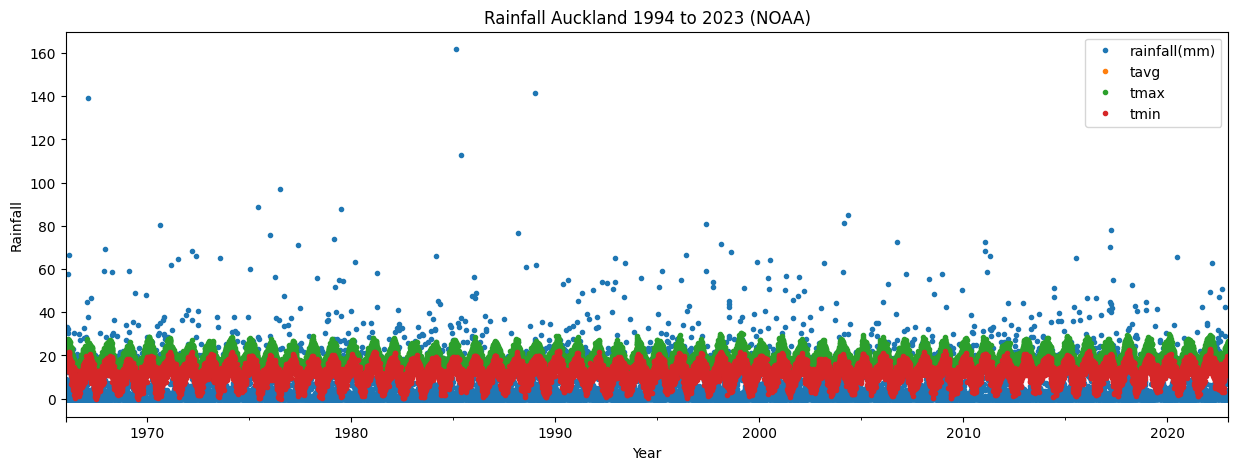

In [105]:
# noaaData = noaaData.set_index('DATE')
# noaaData.index = pd.to_datetime(noaaData.index)
auclandweather.plot(style='.', figsize=(15,5), title='Rainfall Auckland 1994 to 2023 (NOAA)', xlabel="Year", ylabel='Rainfall')

Tras/ Test/ Split

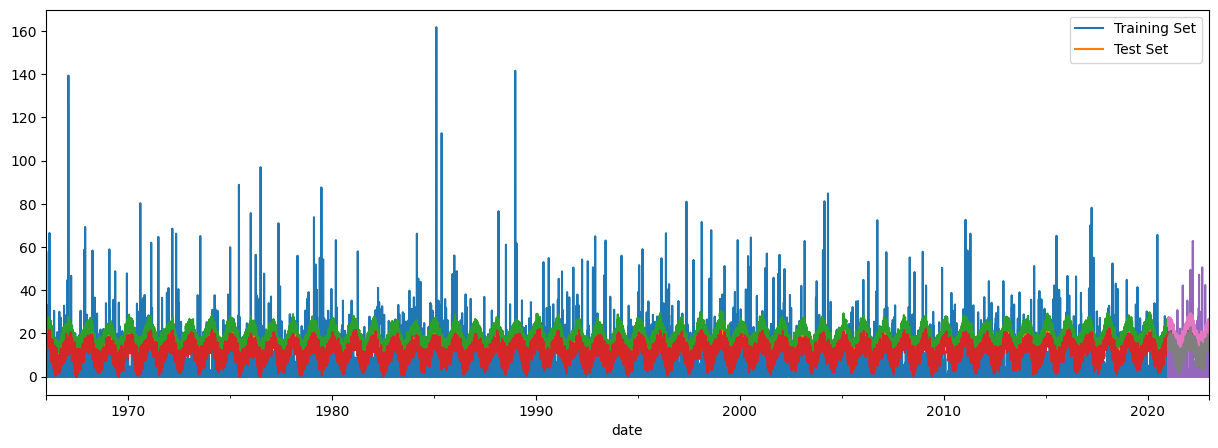

In [106]:
train = auclandweather.loc[auclandweather.index < '2020-12-31']
test = auclandweather.loc[auclandweather.index >= '2020-12-31']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Training Set")
test.plot(ax=ax, label="Testing Set")
ax.legend(['Training Set', 'Test Set'])
plt.show()

look for 2 week of data

<Axes: title={'center': 'Week of Data'}, xlabel='date'>

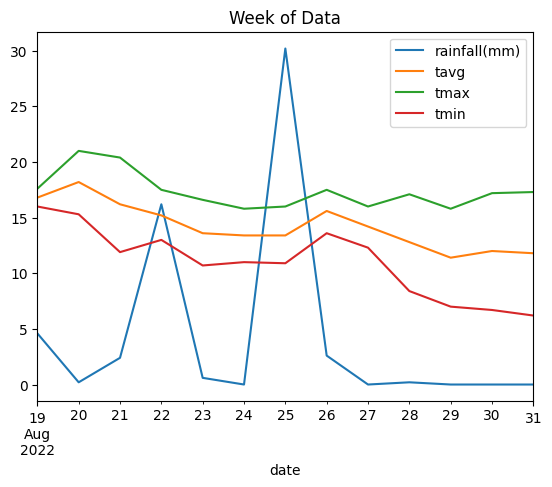

In [107]:
auclandweather.loc[(auclandweather.index > '2022-08-18') & (auclandweather.index < '2022-09-01')].plot(title='Week of Data')

Feature Creation

In [108]:
auclandweather.index.min

<bound method Index.min of DatetimeIndex(['1966-01-01', '1966-01-02', '1966-01-03', '1966-01-04',
               '1966-01-05', '1966-01-06', '1966-01-07', '1966-01-08',
               '1966-01-09', '1966-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='date', length=20819, freq=None)>

Create features

In [109]:
def create_features(df):
    '''
    Create time series features based on time series index
    '''
    df = df.copy()
    df['hour'] = auclandweather.index.hour
    df['dayofweek'] = auclandweather.index.dayofweek
    df['quarter'] = auclandweather.index.quarter
    df['month'] = auclandweather.index.month
    df['year'] = auclandweather.index.year
    df['dayofyear'] = auclandweather.index.dayofyear
    return df

df = create_features(auclandweather)

In [110]:
df

,rainfall(mm),tavg,tmax,tmin,hour,dayofweek,quarter,month,year,dayofyear
date,,,,,,,,,,
1966-01-01,0.0,18.0,22.2,13.9,0,5,1,1,1966,1
1966-01-02,26.2,20.5,23.9,17.1,0,6,1,1,1966,2
1966-01-03,0.0,20.3,23.5,17.1,0,0,1,1,1966,3
1966-01-04,0.0,20.3,24.4,16.2,0,1,1,1,1966,4
1966-01-05,1.3,20.6,23.4,17.8,0,2,1,1,1966,5
...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.0,21.0,25.1,17.0,0,1,4,12,2022,361
2022-12-28,0.0,22.4,26.7,18.1,0,2,4,12,2022,362
2022-12-29,0.0,21.8,25.1,18.6,0,3,4,12,2022,363


Visualize our feature / Target Relationship

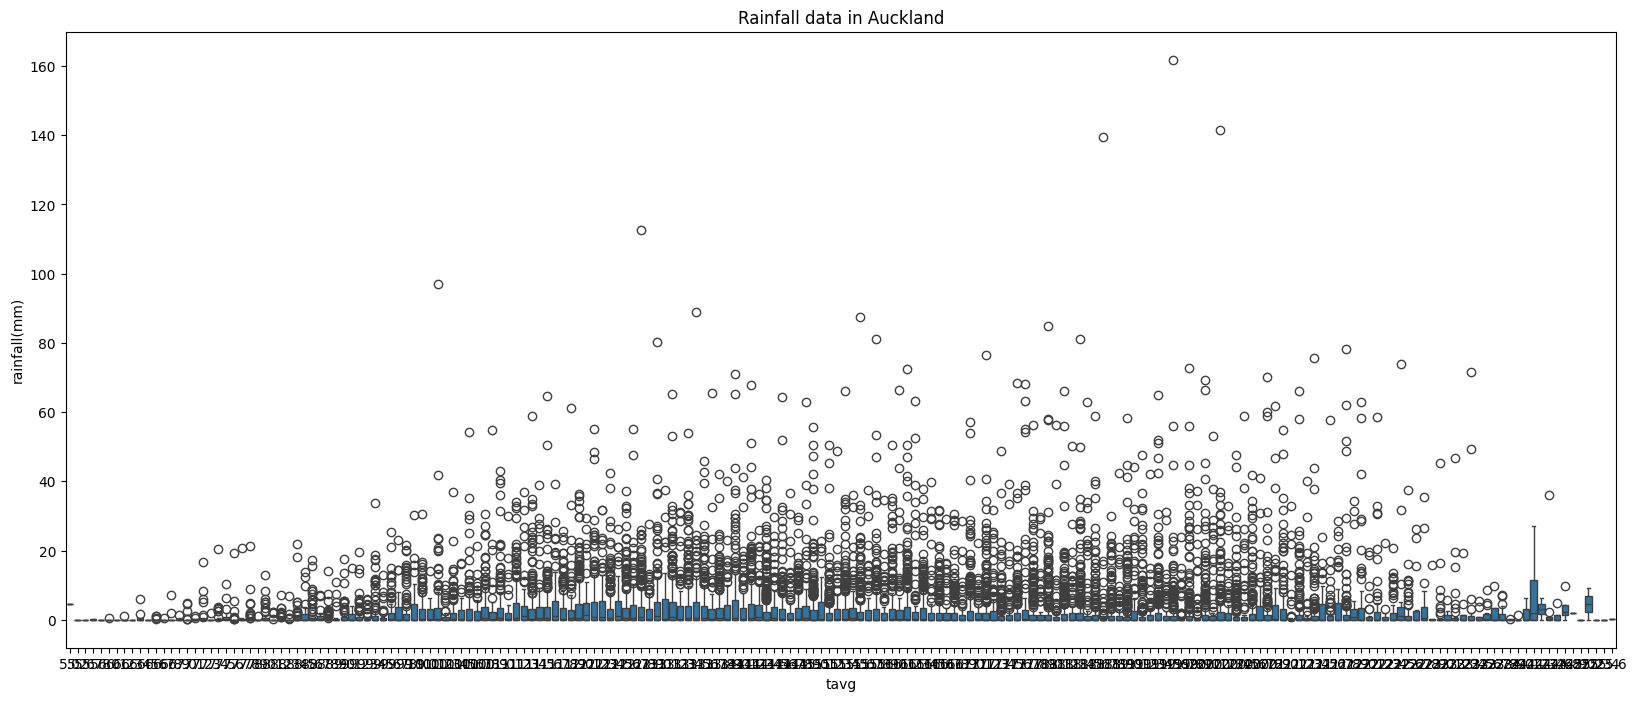

In [111]:
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=auclandweather, x='tavg', y='rainfall(mm)')
ax.set_title('Rainfall data in Auckland')
plt.show()

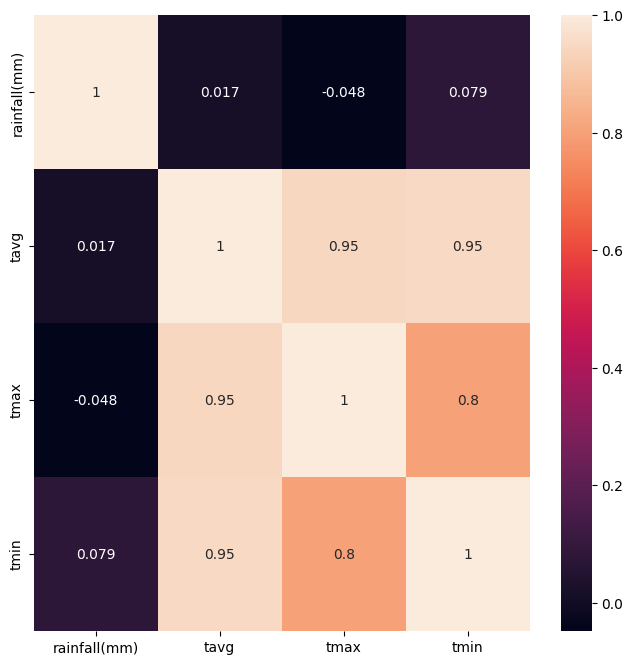

In [112]:

# Heatmap for correlation between variables
import seaborn as sns

# Select only the numeric columns from the 'weather' DataFrame
numeric_columns = auclandweather.select_dtypes(include=[np.number])

plt.figure(figsize=(8, 8))
sns.heatmap(auclandweather.corr(), annot=True)
plt.show()

Create our model

In [113]:
train = create_features(auclandweather)
test = create_features(auclandweather)

In [114]:
df.columns

Index(['rainfall(mm)', 'tavg', 'tmax', 'tmin', 'hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear'],
      dtype='object')

In [116]:
FEATURES = ['tavg', 'tmax', 'tmin']
TARGET = 'rainfall(mm)'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],  verbose=True)

c:\Users\Ying\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Ying\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Ying\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Ying\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use

XGBoostError: [01:49:50] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\data\data.cc:507: Check failed: valid: Label contains NaN, infinity or a value too large.